# Load the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
data_train_raw = pd.read_csv('../input/train.csv')
# data_train_raw = data_train_raw.sample(frac=0.01, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [3]:
data_train_raw.shape

(188318, 132)

# Data EDA and Transformation

In [4]:
def lossRescale(logloss,ymean,ystd):
    loss = (logloss-ymean)/ystd
    return loss
def lossRestore(logloss, ymean, ystd):
    loss = np.exp(logloss*ystd+ymean)
    return loss

In [5]:
shift=200
colLabel = 'logloss'
colRawLabel = 'loss'
labelColumns = [colLabel, colRawLabel]
data_train_raw[colLabel]=np.log(data_train_raw[colRawLabel]+shift)
print('Skewness of raw loss values: {}'.format(data_train_raw[colRawLabel].skew()))
print('Skewness of log1p loss values: {}'.format(data_train_raw[colLabel].skew()))

Skewness of raw loss values: 3.79495837754
Skewness of log1p loss values: 0.301411340599


In [6]:
# ymean=0
# ystd=1
ymean=data_train_raw[colLabel].min()
ystd=(data_train_raw[colLabel]-ymean).max()
data_train_raw[colLabel]=lossRescale(data_train_raw[colLabel],ymean,ystd)

In [7]:
# clean outliers in training data
rescaledMean = data_train_raw[colLabel].mean()
rescaledStd = data_train_raw[colLabel].std()
print('Mean of rescaled log1py: {}'.format(rescaledMean))
print('Std of rescaled log1py: {}'.format(rescaledMean))

lbound = rescaledMean-3*rescaledStd
ubound = rescaledMean+3*rescaledStd
print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
data_train_raw = data_train_raw[(data_train_raw[colLabel]>=lbound) & (data_train_raw[colLabel]<=ubound)]
print('Shape of cleaned data: {}'.format(data_train_raw.shape))
print('Skewness of clipped log1p loss: {}'.format(data_train_raw[colLabel].skew()))

Mean of rescaled log1py: 0.390118205749
Std of rescaled log1py: 0.390118205749
Lower clipping bound: 0.047397382357
Upper clipping bound: 0.732839029142
Shape of cleaned data: (187995, 133)
Skewness of clipped log1p loss: 0.26876327248


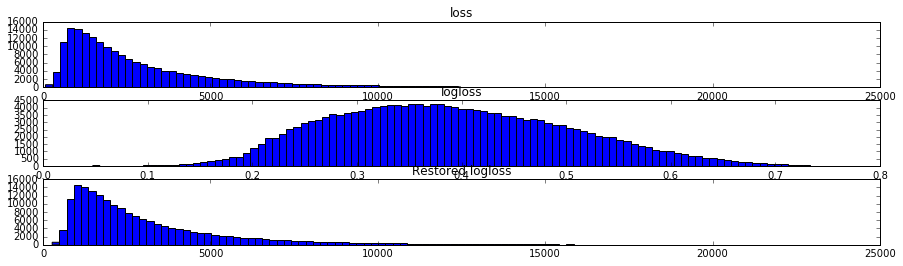

In [8]:
plt.figure(figsize=(15,4))

plt.subplot(3,1,1)
plt.hist(data_train_raw[colRawLabel],100)
plt.title(colRawLabel);
plt.subplot(3,1,2)
plt.hist(data_train_raw[colLabel],100)
plt.title(colLabel);
plt.subplot(3,1,3)
plt.hist(lossRestore(data_train_raw[colLabel],ymean,ystd),100)
plt.title('Restored '+colLabel);

In [9]:
print('Are there any null values?')
print(data_train_raw.isnull().any().any())
print(data_test_raw.isnull().any().any())

Are there any null values?
False
False


In [10]:
print('Logarithmic transformed, rescaled, clipped loss:')
data_train_raw[colLabel].describe()

Logarithmic transformed, rescaled, clipped loss:


count    187995.000000
mean          0.389583
std           0.113253
min           0.047403
25%           0.303756
50%           0.381712
75%           0.469298
max           0.732815
Name: logloss, dtype: float64

# Data preparation - labeling cat features with ordinal information encoded

In [11]:
# save label in a seperate serie
labelSs = data_train_raw[colLabel]
labelColumns.append('id')
trainDf = data_train_raw.drop(labelColumns,axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has {} features from the raw data:\n{}'.format(len(trainDf), trainDf.columns))
print('testDf has {} features from the raw data:\n{}'.format(len(testDf),testDf.columns))

trainDf has 187995 features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has 125546 features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [12]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(313541, 130)
(313541, 116) of which are categorical
(313541, 14) of which are continuous


In [13]:
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK


In [14]:
LevelList = {'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'}
# def LetterRep(x,LevelList):
#     if x in LevelList:
#         x = '0'+x
#     return x
    
def LetterRep(x,LevelList):
    if x in LevelList:
        x = '0'+x
    return x

dataCatAll = dataCatAll.applymap(lambda x: LetterRep(x,LevelList))
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0A,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0J,0G,BU,BC,0C,AS,0S,0A,0O,LB
1,0A,0B,0A,0A,0A,0A,0A,0A,0B,0B,...,0K,0K,BI,CQ,0A,AV,BM,0A,0O,DP
2,0A,0B,0A,0A,0B,0A,0A,0A,0B,0B,...,0F,0A,AB,DK,0A,0C,AF,0A,0I,GK
3,0B,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0K,0K,BI,CS,0C,0N,AE,0A,0O,DJ
4,0A,0B,0A,0B,0A,0A,0A,0A,0B,0B,...,0G,0B,0H,0C,0C,0Y,BM,0A,0K,CK


In [15]:
features = dataCatAll.columns[0:]
cats = [feature for feature in features if feature.startswith('cat')]
for feat in cats:
    dataCatAll[feat] = pd.factorize(dataCatAll[feat], sort=True)[0]
dataCatAll.head()
# le.classes_

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0,1,0,1,0,0,0,0,1,0,...,9,6,68,49,2,43,17,0,14,299
1,0,1,0,0,0,0,0,0,1,1,...,10,10,56,87,0,46,60,0,14,114
2,0,1,0,0,1,0,0,0,1,1,...,5,0,25,106,0,2,28,0,8,184
3,1,1,0,1,0,0,0,0,1,0,...,10,10,56,89,2,13,27,0,14,108
4,0,1,0,1,0,0,0,0,1,1,...,6,1,7,2,2,24,60,0,10,84


In [16]:
# rescale the labeled categorical data
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_catAll = mms.fit_transform(dataCatAll)

In [17]:
print(x_catAll.shape)
x_catAll

(313541, 116)


array([[ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.86416185],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.32947977],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.36363636,  0.53179191],
       ..., 
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
         0.68181818,  0.93063584],
       [ 0.        ,  0.        ,  0.        , ...,  0.22222222,
         0.63636364,  0.31213873],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.5       ,  0.26300578]])

# one-hot-encoding - skipped in order to keep the alphabetical order

In [18]:
# # one-hot-encoding the categorical features
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()
# x_catAll = enc.fit_transform(dataCatAll)
# print(x_catAll.shape)

# split x_train and x_test

In [19]:
# split x_train and x_test
x_train = sp.sparse.hstack((x_catAll[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_test = sp.sparse.hstack((x_catAll[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_train = labelSs.values

# check the dimension of prepared data

In [20]:
print(x_test.shape)
print(x_train.shape)
print(y_train.shape)

(125546, 130)
(187995, 130)
(187995,)


# splite the training data for valication

In [21]:
from sklearn import cross_validation
val_size = 0.1
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_train, y_train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(169195, 130)
(169195,)
(18800, 130)
(18800,)


In [22]:
# del x_Train
# del y_Train
# del x_catAll
# del dataCatAll
# del trainDf
# del testDf

# Model Fitting

In [23]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')

In [24]:
testList = ['XGBoostTrees']

### XGBoost Trees

In [25]:
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))
# def evalerror(preds, dtrain):
#     labels = dtrain.get_label()
#     return 'mae', mean_absolute_error(preds, labels)

In [26]:
import xgboost as xgb
# from sklearn.grid_search import GridSearchCV

In [27]:
d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_test.tocsc())

In [28]:
# params = { 'max_depth': [4, 6, 10], 'min_child_weight':[0,1,2], 'gamma':[0,1,2], \
#            'subsample':[0.5,0.8,1], 'colsample_bytree':[0,1,2], \
#            'eval_metric': 'mae'
#            }
# num_round = 500
# xgbt = GridSearchCV(xgb.XGBRegressor, )

In [34]:
num_round = 4500

# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.05,'min_child_weight':0,'subsample':0.8}# 1187, default RMSE obj function
params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':0.6,'alpha':1,'gamma':0, \
          'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale, 3000 round
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.01,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale
watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]

xgb.cv(params, d_train_xgb, num_boost_round=3500, nfold=5,
             metrics={'mae'}, seed = 0, verbose_eval = True
            )

[0]	train-mae:0.131073+6.21977e-05	test-mae:0.131075+0.000250469
[1]	train-mae:0.129184+0.000105288	test-mae:0.129188+0.00024344
[2]	train-mae:0.127333+0.000137446	test-mae:0.127336+0.000239942
[3]	train-mae:0.12553+0.000116238	test-mae:0.125539+0.000247514
[4]	train-mae:0.123801+0.000144931	test-mae:0.123815+0.000275658
[5]	train-mae:0.122098+0.000135077	test-mae:0.122116+0.000295034
[6]	train-mae:0.120431+0.00012973	test-mae:0.120452+0.000299274
[7]	train-mae:0.118804+0.000124142	test-mae:0.118831+0.000280913
[8]	train-mae:0.117188+0.000111191	test-mae:0.117217+0.000268922
[9]	train-mae:0.115647+0.000128456	test-mae:0.115678+0.000257223
[10]	train-mae:0.114132+0.000136146	test-mae:0.11417+0.000266513
[11]	train-mae:0.112668+0.000126812	test-mae:0.11271+0.000233787
[12]	train-mae:0.111243+0.000125712	test-mae:0.111289+0.000241693
[13]	train-mae:0.109847+0.000125304	test-mae:0.109896+0.000244665
[14]	train-mae:0.108538+0.00012114	test-mae:0.10859+0.000233537
[15]	train-mae:0.10725+0.00

,test-mae-mean,test-mae-std,train-mae-mean,train-mae-std
0,0.131075,0.000250,0.131073,0.000062
1,0.129188,0.000243,0.129184,0.000105
2,0.127336,0.000240,0.127333,0.000137
3,0.125539,0.000248,0.125530,0.000116
4,0.123815,0.000276,0.123801,0.000145
5,0.122116,0.000295,0.122098,0.000135
6,0.120452,0.000299,0.120431,0.000130
7,0.118831,0.000281,0.118804,0.000124
8,0.117217,0.000269,0.117188,0.000111
9,0.115678,0.000257,0.115647,0.000128


In [35]:
gbt = xgb.train(params, d_train_xgb,num_round,watchlist, early_stopping_rounds=3000)

[0]	eval-mae:0.13218	train-mae:0.131107
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 3000 rounds.
[1]	eval-mae:0.130207	train-mae:0.129149
[2]	eval-mae:0.128362	train-mae:0.127315
[3]	eval-mae:0.126485	train-mae:0.125462
[4]	eval-mae:0.124732	train-mae:0.123736
[5]	eval-mae:0.122971	train-mae:0.121992
[6]	eval-mae:0.121278	train-mae:0.120327
[7]	eval-mae:0.119582	train-mae:0.118651
[8]	eval-mae:0.11793	train-mae:0.11702
[9]	eval-mae:0.116378	train-mae:0.115489
[10]	eval-mae:0.114863	train-mae:0.113998
[11]	eval-mae:0.113438	train-mae:0.112591
[12]	eval-mae:0.111981	train-mae:0.111164
[13]	eval-mae:0.110554	train-mae:0.109756
[14]	eval-mae:0.10917	train-mae:0.108397
[15]	eval-mae:0.107849	train-mae:0.107101
[16]	eval-mae:0.106562	train-mae:0.105826
[17]	eval-mae:0.105306	train-mae:0.104595
[18]	eval-mae:0.104094	train-mae:0.103405
[19]	eval-mae:0.102888	train-mae:0.102219
[20]	eval-mae:0.101715	train-

In [36]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd)-shift,lossRestore(gbt.predict(x_val_xgb),ymean,ystd)-shift))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd)-shift,lossRestore(gbt.predict(x_val_xgb),ymean,ystd)-shift))
# print(mean_absolute_error(y_val,gbt.predict(x_val_xgb)))

1091.96141335


In [37]:
# fig = plt.figure(figsize=(20,35))

# xgb.plot_importance(gbt,ax = fig.gca() );

(0, 23000)

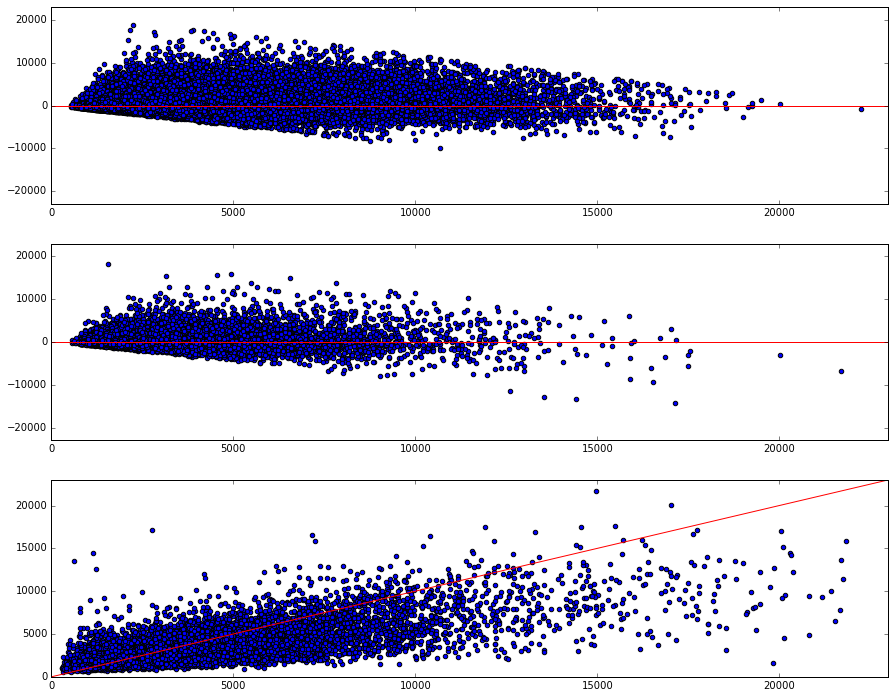

In [38]:
y_val_pred_xgb = gbt.predict(x_val_xgb)
y_val_err = lossRestore(y_val,ymean,ystd)-lossRestore(y_val_pred_xgb,ymean,ystd)

y_train_pred_xgb = gbt.predict(d_train_xgb)
y_train_err = lossRestore(y_train,ymean,ystd)-lossRestore(y_train_pred_xgb,ymean,ystd)

xlim = [0,23000]
ylim = [-23000,23000]

plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.scatter(lossRestore(y_train_pred_xgb,ymean,ystd),y_train_err);
plt.plot([0,23000],[0,0],'r');
plt.ylim(ylim)
plt.xlim(xlim)

plt.subplot(3,1,2)
plt.scatter(lossRestore(y_val_pred_xgb,ymean,ystd),y_val_err);
plt.plot([0,23000],[0,0],'r');
plt.ylim(ylim)
plt.xlim(xlim)

plt.subplot(3,1,3)
plt.scatter(lossRestore(y_val,ymean,ystd),lossRestore(y_val_pred_xgb,ymean,ystd));
plt.plot([0,23000],[0,23000],'r');
plt.ylim(xlim)
plt.xlim(xlim)

### 2nd Round XGBoost with Weighted Samples

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1)

[ 0.32577227  0.36757248  0.3350349  ...,  0.33996577  0.32796332
  0.33103755]
DescribeResult(nobs=169195, minmax=(-9781.2435937499995, 18816.891416015609), mean=316.34030729288349, variance=2411404.4503057664, skewness=2.0600696984156937, kurtosis=9.843560221353682)


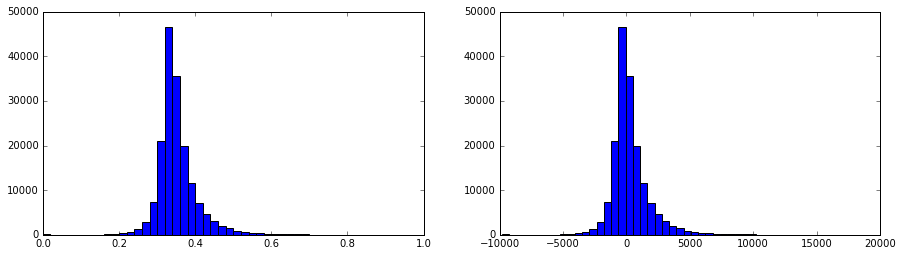

In [44]:
# create the weights
mms = MinMaxScaler()
sample_weights = y_train_err
# sample_weights[y_train_err<0] *= 2
# sample_weights[y_train_err>=0] *= 1.0
# sample_weights = (mms.fit_transform(np.exp(-1*np.square(sample_weights)/2/np.square(5000)))) \
#                  + mms.fit_transform((sample_weights))
# sample_weights = (mms.fit_transform(np.exp(-1*np.square(sample_weights)/2/np.square(8000)))) \
#                  + 1-mms.fit_transform(np.exp(-1*np.tanh(sample_weights/2000)))
# sample_weights = 1-mms.fit_transform(np.exp(-1*np.tanh(sample_weights/2000)))
sample_weights = 1-mms.fit_transform((-1*(sample_weights/2000)))
sample_weights = mms.fit_transform((sample_weights))
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(sample_weights,bins=50);
plt.subplot(1,2,2)
plt.hist(y_train_err,bins=50)
np.isnan(sample_weights).any()
print(sample_weights)
print(sp.stats.describe(y_train_err))

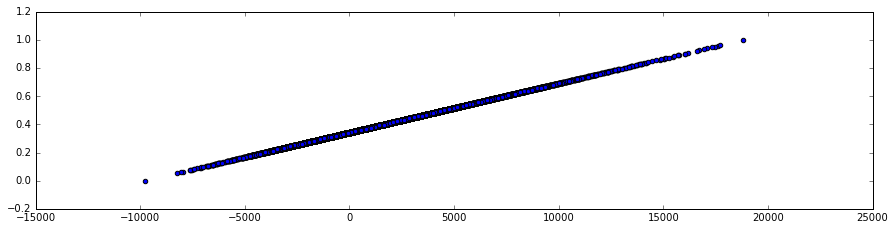

In [45]:
plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.scatter(y_train_err,sample_weights);
# plt.plot([0,23000],[0,0],'r');

In [46]:
d_train_xgb_2 = xgb.DMatrix(x_train.tocsc(),label=y_train,weight=sample_weights)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_test.tocsc())

In [47]:
d_train_xgb_2.get_weight()

array([ 0.32577226,  0.36757249,  0.33503491, ...,  0.33996576,
        0.32796332,  0.33103755], dtype=float32)

In [48]:
num_round = 3000

# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.05,'min_child_weight':0,'subsample':0.8}# 1187, default RMSE obj function
# params_2 = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale, 3000 round
params_2 = {'eval_metric':'mae','max_depth':6,'colsample_bytree':0.6,'alpha':1,'gamma':0, \
          'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale
watchlist_2  = [(d_val_xgb,'eval'), (d_train_xgb_2,'train')]

# gbt_2 = xgb.train(params_2, d_train_xgb_2,num_round,watchlist_2, obj=logregobj, early_stopping_rounds=3000)
gbt_2 = xgb.train(params_2, d_train_xgb_2,num_round,watchlist_2, early_stopping_rounds=3000)

[0]	eval-mae:0.132293	train-mae:0.12686
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 3000 rounds.
[1]	eval-mae:0.130429	train-mae:0.125086
[2]	eval-mae:0.128686	train-mae:0.123441
[3]	eval-mae:0.126905	train-mae:0.121761
[4]	eval-mae:0.125248	train-mae:0.120217
[5]	eval-mae:0.123575	train-mae:0.118636
[6]	eval-mae:0.121972	train-mae:0.117139
[7]	eval-mae:0.120359	train-mae:0.11562
[8]	eval-mae:0.118792	train-mae:0.114144
[9]	eval-mae:0.117313	train-mae:0.112769
[10]	eval-mae:0.115871	train-mae:0.11143
[11]	eval-mae:0.114515	train-mae:0.110182
[12]	eval-mae:0.113118	train-mae:0.108895
[13]	eval-mae:0.111754	train-mae:0.107624
[14]	eval-mae:0.110432	train-mae:0.1064
[15]	eval-mae:0.10916	train-mae:0.105229
[16]	eval-mae:0.107915	train-mae:0.104074
[17]	eval-mae:0.106707	train-mae:0.102968
[18]	eval-mae:0.105539	train-mae:0.101903
[19]	eval-mae:0.104377	train-mae:0.100832
[20]	eval-mae:0.103244	train-ma

In [51]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd)-shift,lossRestore(gbt.predict(x_val_xgb),ymean,ystd)-shift))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd)-shift,lossRestore(gbt_2.predict(x_val_xgb),ymean,ystd)-shift))
# print(mean_absolute_error(y_val,gbt.predict(x_val_xgb)))

1098.19904108


(0, 23000)

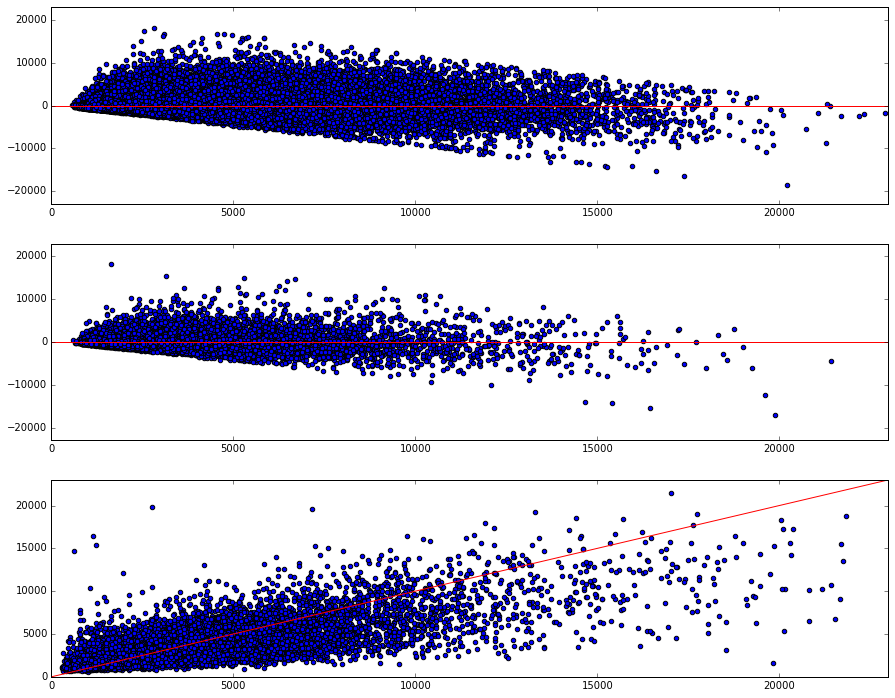

In [52]:
y_val_pred_xgb_2 = gbt_2.predict(x_val_xgb)
y_val_err_2 = lossRestore(y_val,ymean,ystd)-lossRestore(y_val_pred_xgb_2,ymean,ystd)

y_train_pred_xgb_2 = gbt_2.predict(d_train_xgb_2)
y_train_err_2 = lossRestore(y_train,ymean,ystd)-lossRestore(y_train_pred_xgb_2,ymean,ystd)

xlim = [0,23000]
ylim = [-23000,23000]

plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.scatter(lossRestore(y_train_pred_xgb_2,ymean,ystd),y_train_err_2);
plt.plot([0,23000],[0,0],'r');
plt.ylim(ylim)
plt.xlim(xlim)

plt.subplot(3,1,2)
plt.scatter(lossRestore(y_val_pred_xgb_2,ymean,ystd),y_val_err_2);
plt.plot([0,23000],[0,0],'r');
plt.ylim(ylim)
plt.xlim(xlim)

plt.subplot(3,1,3)
plt.scatter(lossRestore(y_val,ymean,ystd),lossRestore(y_val_pred_xgb_2,ymean,ystd));
plt.plot([0,23000],[0,23000],'r');
plt.ylim(xlim)
plt.xlim(xlim)

### 3nd Round XGBoost

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1)

[ 1.49306737  1.46732887  1.49031739 ...,  1.48901671  1.37090076
  1.31184967]
DescribeResult(nobs=150396, minmax=(-18489.580078125, 19026.122617187484), mean=118.53963240011865, variance=2625488.302477493, skewness=1.4451429962545272, kurtosis=10.17091491089154)


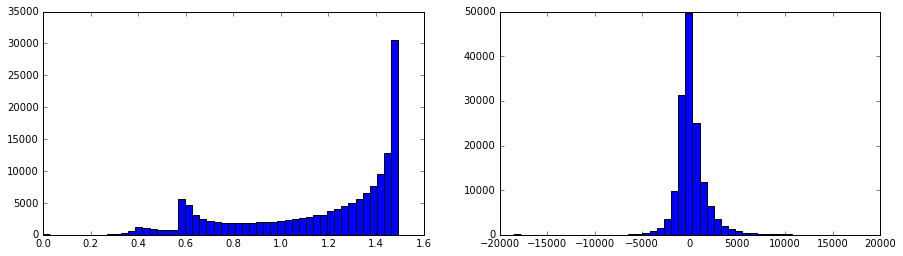

In [206]:
# create the weights
mms = MinMaxScaler()
sample_weights = y_train_err_2
sample_weights = mms.fit_transform(np.exp(-1*np.square(sample_weights)/2/np.square(1000))) \
                 + mms.fit_transform((sample_weights))
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(sample_weights,bins=50);
plt.subplot(1,2,2)
plt.hist(y_train_err_2,bins=50)
np.isnan(sample_weights).any()
print(sample_weights)
print(sp.stats.describe(y_train_err_2))

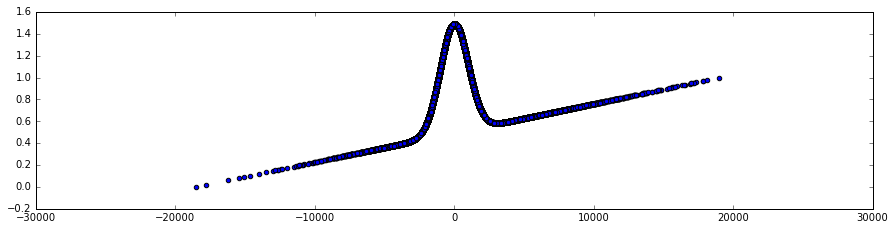

In [207]:
plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.scatter(y_train_err_2,sample_weights);
# plt.plot([0,23000],[0,0],'r');

In [208]:
d_train_xgb_3 = xgb.DMatrix(x_train.tocsc(),label=y_train,weight=sample_weights)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_test.tocsc())

In [209]:
num_round = 3000

# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.05,'min_child_weight':0,'subsample':0.8}# 1187, default RMSE obj function
# params_2 = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale, 3000 round
params_3 = {'eval_metric':'mae','max_depth':6,'colsample_bytree':0.6,'alpha':1,'gamma':0, \
          'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale
watchlist_3  = [(d_val_xgb,'eval'), (d_train_xgb_3,'train')]

# gbt_2 = xgb.train(params_2, d_train_xgb_2,num_round,watchlist_2, obj=logregobj, early_stopping_rounds=3000)
gbt_3 = xgb.train(params_2, d_train_xgb_3,num_round,watchlist_3, early_stopping_rounds=3000)

[0]	eval-mae:0.131835	train-mae:0.137631
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 3000 rounds.
[1]	eval-mae:0.129773	train-mae:0.135332
[2]	eval-mae:0.12778	train-mae:0.133088
[3]	eval-mae:0.125849	train-mae:0.130913
[4]	eval-mae:0.12395	train-mae:0.128771
[5]	eval-mae:0.122142	train-mae:0.126716
[6]	eval-mae:0.120362	train-mae:0.12469
[7]	eval-mae:0.11861	train-mae:0.122682
[8]	eval-mae:0.116943	train-mae:0.120779
[9]	eval-mae:0.115309	train-mae:0.118908
[10]	eval-mae:0.113748	train-mae:0.11711
[11]	eval-mae:0.11221	train-mae:0.115329
[12]	eval-mae:0.110692	train-mae:0.113569
[13]	eval-mae:0.109219	train-mae:0.111856
[14]	eval-mae:0.107855	train-mae:0.110268
[15]	eval-mae:0.106525	train-mae:0.108717
[16]	eval-mae:0.1052	train-mae:0.107159
[17]	eval-mae:0.104022	train-mae:0.105765
[18]	eval-mae:0.102759	train-mae:0.104274
[19]	eval-mae:0.10152	train-mae:0.102809
[20]	eval-mae:0.100373	train-mae:0

In [210]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd)-shift,lossRestore(gbt.predict(x_val_xgb),ymean,ystd)-shift))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd)-shift,lossRestore(gbt_3.predict(x_val_xgb),ymean,ystd)-shift))
# print(mean_absolute_error(y_val,gbt.predict(x_val_xgb)))

1102.84975096


(0, 23000)

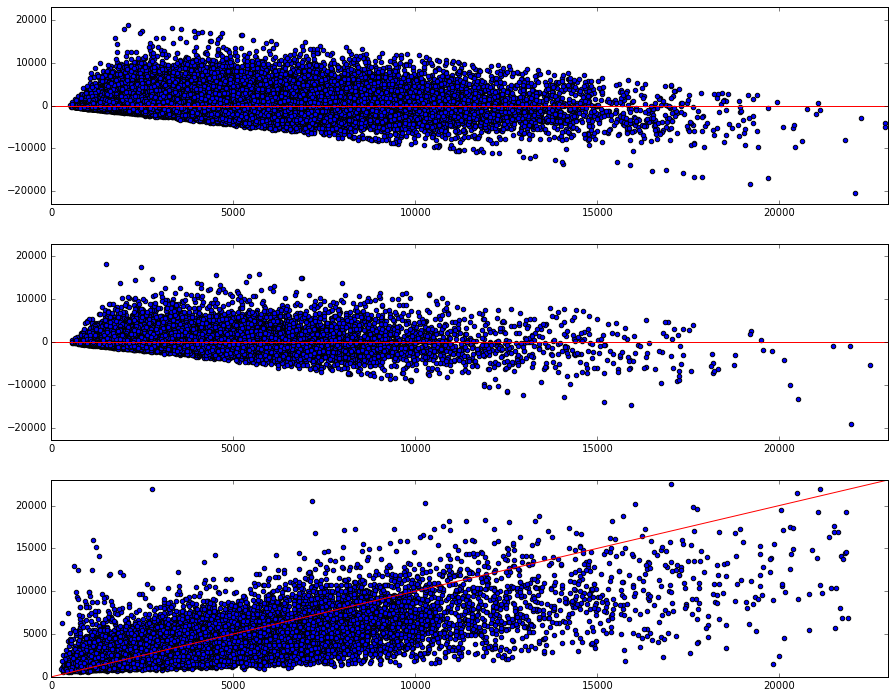

In [212]:
y_val_pred_xgb_3 = gbt_3.predict(x_val_xgb)
y_val_err_3 = lossRestore(y_val,ymean,ystd)-lossRestore(y_val_pred_xgb_3,ymean,ystd)

y_train_pred_xgb_3 = gbt_3.predict(d_train_xgb_3)
y_train_err_3 = lossRestore(y_train,ymean,ystd)-lossRestore(y_train_pred_xgb_3,ymean,ystd)

xlim = [0,23000]
ylim = [-23000,23000]

plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.scatter(lossRestore(y_train_pred_xgb_3,ymean,ystd),y_train_err_3);
plt.plot([0,23000],[0,0],'r');
plt.ylim(ylim)
plt.xlim(xlim)

plt.subplot(3,1,2)
plt.scatter(lossRestore(y_val_pred_xgb_3,ymean,ystd),y_val_err_3);
plt.plot([0,23000],[0,0],'r');
plt.ylim(ylim)
plt.xlim(xlim)

plt.subplot(3,1,3)
plt.scatter(lossRestore(y_val,ymean,ystd),lossRestore(y_val_pred_xgb_3,ymean,ystd));
plt.plot([0,23000],[0,23000],'r');
plt.ylim(xlim)
plt.xlim(xlim)

### 4th XGBoost

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


[ 0.52144703  0.52326375  0.52202874 ...,  0.5209508   0.50819345
  0.50436437]
DescribeResult(nobs=150396, minmax=(-20323.654296875, 18957.828916015609), mean=276.23736464439929, variance=2752299.0609923061, skewness=1.487271276825999, kurtosis=9.962861270502936)


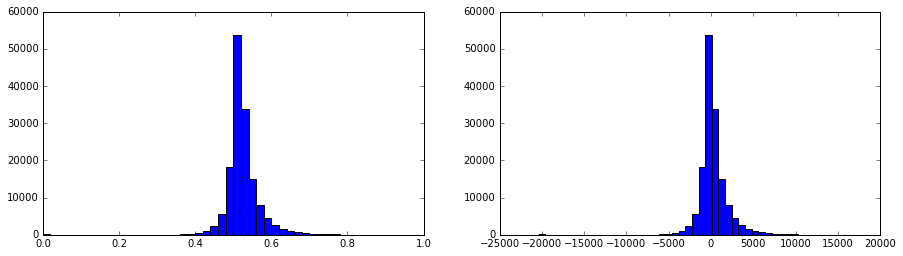

In [213]:
# create the weights
mms = MinMaxScaler()
sample_weights = y_train_err_3
# sample_weights[y_train_err<0] *= 2
# sample_weights[y_train_err>=0] *= 1.0
# sample_weights = mms.fit_transform(np.exp(-1*np.square(sample_weights)/2/np.square(2500)))
# sample_weights = 1-mms.fit_transform(np.exp(-1*np.tanh(sample_weights/3500)))
sample_weights = mms.fit_transform((sample_weights))
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(sample_weights,bins=50);
plt.subplot(1,2,2)
plt.hist(y_train_err_3,bins=50)
np.isnan(sample_weights).any()
print(sample_weights)
print(sp.stats.describe(y_train_err_3))

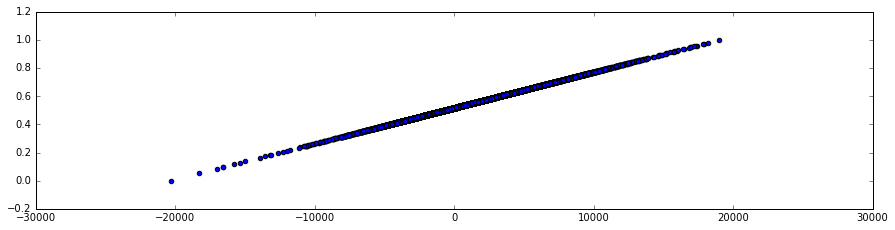

In [214]:
plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.scatter(y_train_err_3,sample_weights);
# plt.plot([0,23000],[0,0],'r');

In [215]:
d_train_xgb_4 = xgb.DMatrix(x_train.tocsc(),label=y_train,weight=sample_weights)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_test.tocsc())

In [216]:
num_round = 3000

# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.05,'min_child_weight':0,'subsample':0.8}# 1187, default RMSE obj function
# params_2 = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale, 3000 round
params_3 = {'eval_metric':'mae','max_depth':6,'colsample_bytree':0.6,'alpha':1,'gamma':0, \
          'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale
watchlist_4  = [(d_val_xgb,'eval'), (d_train_xgb_4,'train')]

# gbt_2 = xgb.train(params_2, d_train_xgb_2,num_round,watchlist_2, obj=logregobj, early_stopping_rounds=3000)
gbt_4 = xgb.train(params_3, d_train_xgb_4,num_round,watchlist_4, early_stopping_rounds=3000)

[0]	eval-mae:0.131995	train-mae:0.129125
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 3000 rounds.
[1]	eval-mae:0.130084	train-mae:0.127276
[2]	eval-mae:0.12823	train-mae:0.125475
[3]	eval-mae:0.126433	train-mae:0.123738
[4]	eval-mae:0.124668	train-mae:0.122027
[5]	eval-mae:0.12299	train-mae:0.120403
[6]	eval-mae:0.12132	train-mae:0.118791
[7]	eval-mae:0.119678	train-mae:0.117195
[8]	eval-mae:0.118127	train-mae:0.1157
[9]	eval-mae:0.116596	train-mae:0.114223
[10]	eval-mae:0.115144	train-mae:0.112822
[11]	eval-mae:0.113695	train-mae:0.111422
[12]	eval-mae:0.112266	train-mae:0.110041
[13]	eval-mae:0.110876	train-mae:0.108702
[14]	eval-mae:0.109608	train-mae:0.10749
[15]	eval-mae:0.108364	train-mae:0.106301
[16]	eval-mae:0.107117	train-mae:0.105103
[17]	eval-mae:0.106014	train-mae:0.104054
[18]	eval-mae:0.104815	train-mae:0.102899
[19]	eval-mae:0.103631	train-mae:0.101767
[20]	eval-mae:0.102548	train-ma

In [217]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd)-shift,lossRestore(gbt.predict(x_val_xgb),ymean,ystd)-shift))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd)-shift,lossRestore(gbt_4.predict(x_val_xgb),ymean,ystd)-shift))
# print(mean_absolute_error(y_val,gbt.predict(x_val_xgb)))

1101.95503162


(0, 23000)

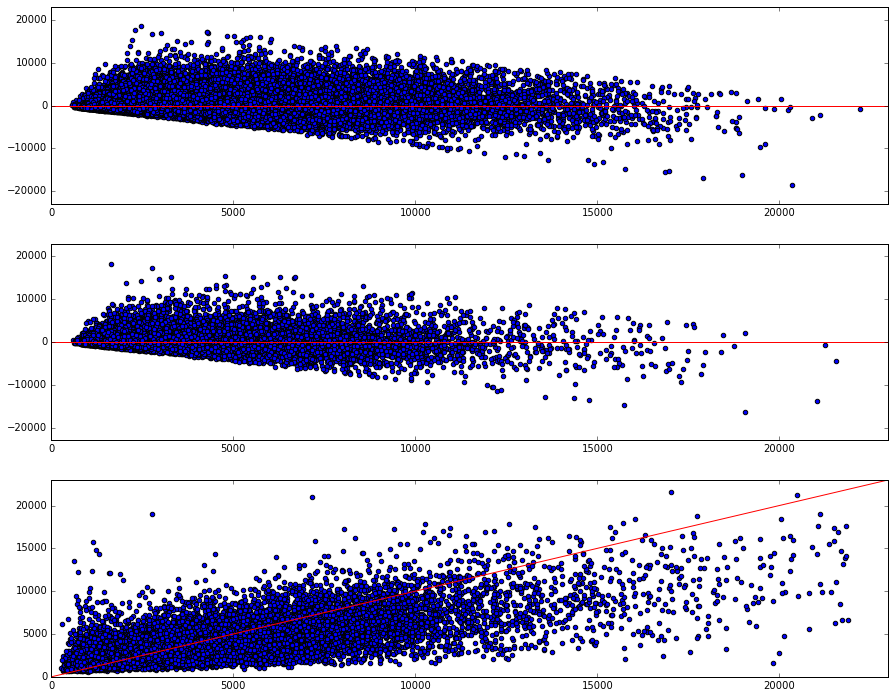

In [218]:
y_val_pred_xgb_4 = gbt_4.predict(x_val_xgb)
y_val_err_4 = lossRestore(y_val,ymean,ystd)-lossRestore(y_val_pred_xgb_4,ymean,ystd)

y_train_pred_xgb_4 = gbt_4.predict(d_train_xgb_4)
y_train_err_4 = lossRestore(y_train,ymean,ystd)-lossRestore(y_train_pred_xgb_4,ymean,ystd)

xlim = [0,23000]
ylim = [-23000,23000]

plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.scatter(lossRestore(y_train_pred_xgb_4,ymean,ystd),y_train_err_4);
plt.plot([0,23000],[0,0],'r');
plt.ylim(ylim)
plt.xlim(xlim)

plt.subplot(3,1,2)
plt.scatter(lossRestore(y_val_pred_xgb_4,ymean,ystd),y_val_err_4);
plt.plot([0,23000],[0,0],'r');
plt.ylim(ylim)
plt.xlim(xlim)

plt.subplot(3,1,3)
plt.scatter(lossRestore(y_val,ymean,ystd),lossRestore(y_val_pred_xgb_4,ymean,ystd));
plt.plot([0,23000],[0,23000],'r');
plt.ylim(xlim)
plt.xlim(xlim)

### Save Prediction Results

In [53]:
# y_pred_i = gbt_3.predict(d_test_xgb)
# y_pred.append(lossRestore(y_pred_i,ymean,ystd)-shift)
# y_pred_val.append(lossRestore(gbt_3.predict(x_val_xgb),ymean,ystd)-shift)
y_pred_i = gbt.predict(d_test_xgb)
y_pred.append(lossRestore(y_pred_i,ymean,ystd)-shift)
y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd)-shift)

# save files for submission

In [54]:
# # remove the shift
# y_pred = [y_array-shift for y_array in y_pred];
# y_pred_val_en = [y_array-shift for y_array in y_pred_val_en];

In [55]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

In [56]:
from sklearn.externals import joblib
joblib.dump([gbt, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_test, shift]
            ,'../output/models-raw-features-rescale-loss-shift.pkl',compress=3) 

# clf = joblib.load('filename.pkl') 

['../output/models-raw-features-rescale-loss-shift.pkl']

In [ ]:
testList
